In [10]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_abj/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)
k_sampling_points = 120



curve_bs.shape: (79, 119, 3)
files length: 79


In [16]:
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_


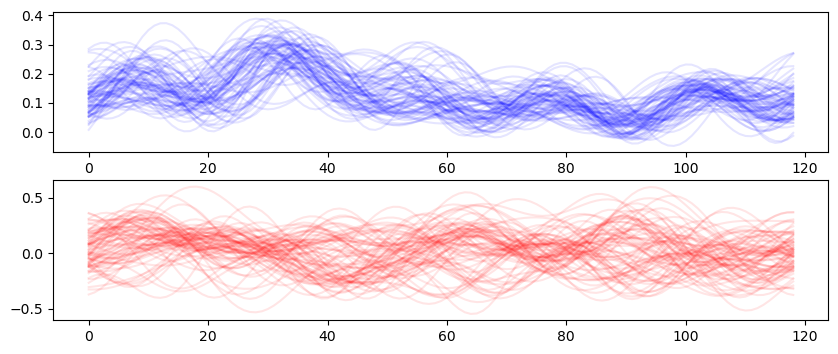

In [34]:
curvatures = []
torsions = []

for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(curve_cs[i]*100)
    fft_c = remove_high_freq_components(c,0.05)
    fft_t = remove_high_freq_components(t,0.05)
    curvatures.append(fft_c)
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(curvatures.T, color='blue', alpha=0.1)
ax2.plot(torsions.T, color='red', alpha=0.1)

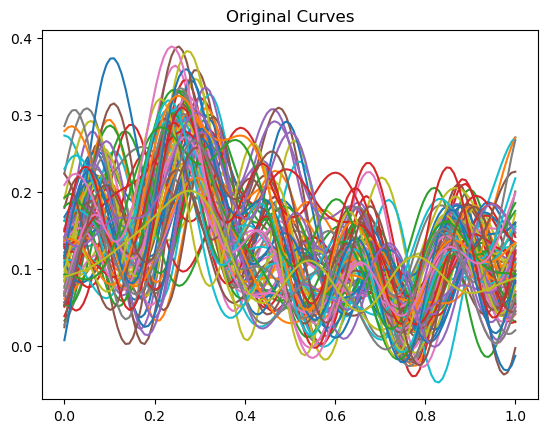

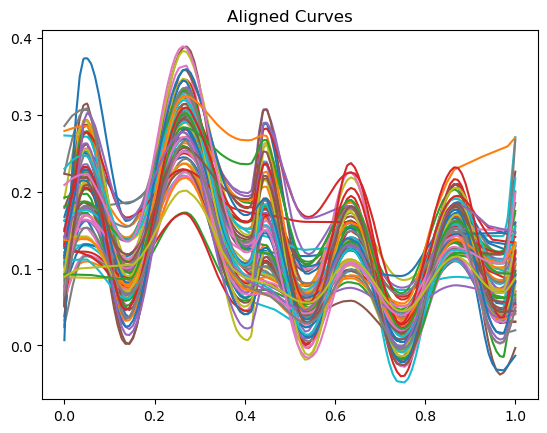

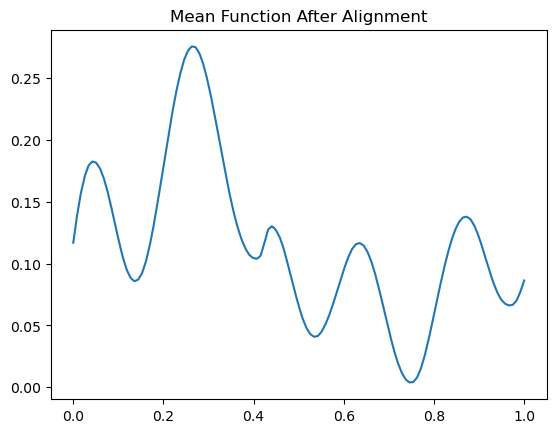

In [35]:
# !pip install scikit-fda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda import FDataGrid

# curvatures = curve_bs[:,:,2]

n, k = curvatures.shape
x_grid = np.linspace(0, 1, k)

fd = FDataGrid(data_matrix=curvatures, grid_points=x_grid)

# 可视化原始曲线
fd.plot()
plt.title("Original Curves")
plt.show()

# 创建 FisherRaoElasticRegistration 对象
elastic_registration = FisherRaoElasticRegistration()

# 执行曲线对齐
fd_aligned = elastic_registration.fit_transform(fd)

# 可视化对齐后的曲线
fd_aligned.plot()
plt.title("Aligned Curves")
plt.show()

# 计算对齐后的均值曲线 (Karcher Mean)
mean_function = fisher_rao_karcher_mean(fd_aligned)

# 可视化均值曲线
mean_function.plot()
plt.title("Mean Function After Alignment")
plt.show()